### 2018/2019 - Task List 10

1. Implement Naive Bayes classifier with pyro
    - create apropriate parameters (mean and std for a and b, sigma - noise)
    - provide optimization procedure
    - check appropriateness of implemented method with selected dataset


# Required imports

In [1]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from tqdm import tqdm
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive

In [2]:
pyro.set_rng_seed(1)
pyro.enable_validation(True)

## Solutions

In [39]:
from numpy import pi
import numpy as np

class GaussianNaiveBayes(nn.Module):
    """ Implementation of Naive Bayes as a layer for pytorch models
    TODO
    ----
    - Make std devs fixable
    - Look into better param initialization
    """
    def __init__(self, features, classes):
        super(self.__class__, self).__init__()

        self.features = features
        self.classes = classes
        self.means = nn.Parameter(torch.zeros(classes, features))
        self.variances = nn.Parameter(torch.ones(classes, features))
        self.class_priors = nn.Parameter(torch.Tensor(self.classes))

    def forward(self, x):
        x = x[:,np.newaxis,:]
        return (torch.sum(- 0.5 * torch.log(2 * pi * torch.abs(self.variances))
                - (x - self.means)**2 / torch.abs(self.variances) / 2, dim=-1)
                + torch.log(self.class_priors))

In [40]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
feature_train_v = torch.FloatTensor(X_train)
labels_train_v = torch.FloatTensor(y_train)
feature_test_v = torch.FloatTensor(X_test)
labels_test_v = torch.FloatTensor(y_test)

In [42]:
import pyro
from pyro.distributions import Cauchy, Categorical, Normal, Beta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from tqdm import tqdm
softmax = nn.Softmax(dim=1)
my_class_priors = torch.Tensor(np.histogram(labels_train_v, bins=[i for i in range(4)])[0]/len(labels_train_v))

In [43]:
bayes_model = GaussianNaiveBayes(4, 3)
bayes_model.class_priors.data = my_class_priors

In [44]:
def model(x_data, y_data):
    # weight and bias priors
    mean_prior = Normal(loc=torch.zeros_like(bayes_model.means),
                        scale=torch.ones_like(bayes_model.variances)).independent(2)
    var_prior = Normal(loc=torch.zeros_like(bayes_model.means),
                        scale=torch.ones_like(bayes_model.variances)).independent(2)
        
    priors = {'means': mean_prior, 'variances': var_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", bayes_model, priors)
    # sample a nn (which also samples w and b)
    lifted_bayes_model = lifted_module()
    with pyro.plate("map", len(x_data)):
        # run the nn forward on data
        prediction_mean = lifted_bayes_model(x_data)
        # condition on the observed data
        hat = softmax(prediction_mean)
        obs = pyro.sample("obs", Categorical(logits=hat), obs=y_data)
        return hat

In [45]:
def guide(x_data, y_data):
    mean_prior = Normal(loc=torch.rand_like(bayes_model.means)*5,
                        scale=torch.ones_like(bayes_model.variances)).independent(2)
    mean_prior_param = pyro.param('means', mean_prior)
    var_prior = Normal(loc=torch.rand_like(bayes_model.means)*2,
                        scale=torch.ones_like(bayes_model.variances)).independent(2)
    var_prior_param = pyro.param('variances', var_prior)
    
    priors = {'means': mean_prior, 'variances': var_prior}
    
    lifted_module = pyro.random_module("module", bayes_model, priors)
    
    return lifted_module()

In [46]:
def train():
    pyro.clear_param_store()
    num_iterations=1000
    optim = pyro.optim.Adam({"lr": 0.01})
    svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(), num_samples=50)
    t=tqdm(range(num_iterations))
    for j in t:
        loss = svi.step(feature_train_v,  labels_train_v)
        t.set_postfix(loss=loss)
    return (model, svi)

In [47]:
probabilistic_model, svi = train()




  0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 0/1000 [00:00<?, ?it/s, loss=180]


  0%|          | 0/1000 [00:00<?, ?it/s, loss=160]


  0%|          | 0/1000 [00:00<?, ?it/s, loss=152]


  0%|          | 0/1000 [00:00<?, ?it/s, loss=186]


  0%|          | 0/1000 [00:00<?, ?it/s, loss=184]


  0%|          | 5/1000 [00:00<00:21, 45.45it/s, loss=184]


  0%|          | 5/1000 [00:00<00:21, 45.45it/s, loss=161]


  0%|          | 5/1000 [00:00<00:21, 45.45it/s, loss=206]


  0%|          | 5/1000 [00:00<00:21, 45.45it/s, loss=202]


  0%|          | 5/1000 [00:00<00:21, 45.45it/s, loss=182]


  0%|          | 5/1000 [00:00<00:21, 45.45it/s, loss=187]


  0%|          | 5/1000 [00:00<00:21, 45.45it/s, loss=193]


  0%|          | 5/1000 [00:00<00:21, 45.45it/s, loss=195]


  1%|          | 12/1000 [00:00<00:19, 50.16it/s, loss=195]


  1%|          | 12/1000 [00:00<00:19, 50.16it/s, loss=159]


  1%|          | 12/1000 [00:00<00:19, 50.16it/s, loss=188]


  1%|          

 10%|▉         | 98/1000 [00:01<00:19, 46.58it/s, loss=160]


 10%|▉         | 98/1000 [00:01<00:19, 46.58it/s, loss=194]


 10%|▉         | 98/1000 [00:01<00:19, 46.58it/s, loss=186]


 10%|▉         | 98/1000 [00:01<00:19, 46.58it/s, loss=214]


 10%|█         | 105/1000 [00:01<00:17, 50.80it/s, loss=214]


 10%|█         | 105/1000 [00:01<00:17, 50.80it/s, loss=196]


 10%|█         | 105/1000 [00:01<00:17, 50.80it/s, loss=206]


 10%|█         | 105/1000 [00:01<00:17, 50.80it/s, loss=173]


 10%|█         | 105/1000 [00:01<00:17, 50.80it/s, loss=186]


 10%|█         | 105/1000 [00:01<00:17, 50.80it/s, loss=161]


 10%|█         | 105/1000 [00:01<00:17, 50.80it/s, loss=195]


 10%|█         | 105/1000 [00:01<00:17, 50.80it/s, loss=217]


 11%|█         | 112/1000 [00:01<00:16, 54.85it/s, loss=217]


 11%|█         | 112/1000 [00:01<00:16, 54.85it/s, loss=158]


 11%|█         | 112/1000 [00:01<00:16, 54.85it/s, loss=141]


 11%|█         | 112/1000 [00:01<00:16, 54.85it/s, loss=193

 19%|█▉        | 193/1000 [00:03<00:10, 78.15it/s, loss=201]


 20%|██        | 203/1000 [00:03<00:09, 81.91it/s, loss=201]


 20%|██        | 203/1000 [00:03<00:09, 81.91it/s, loss=131]


 20%|██        | 203/1000 [00:03<00:09, 81.91it/s, loss=178]


 20%|██        | 203/1000 [00:03<00:09, 81.91it/s, loss=171]


 20%|██        | 203/1000 [00:03<00:09, 81.91it/s, loss=130]


 20%|██        | 203/1000 [00:03<00:09, 81.91it/s, loss=194]


 20%|██        | 203/1000 [00:03<00:09, 81.91it/s, loss=227]


 20%|██        | 203/1000 [00:03<00:09, 81.91it/s, loss=131]


 20%|██        | 203/1000 [00:03<00:09, 81.91it/s, loss=217]


 20%|██        | 203/1000 [00:03<00:09, 81.91it/s, loss=176]


 20%|██        | 203/1000 [00:03<00:09, 81.91it/s, loss=185]


 21%|██▏       | 213/1000 [00:03<00:09, 84.64it/s, loss=185]


 21%|██▏       | 213/1000 [00:03<00:09, 84.64it/s, loss=153]


 21%|██▏       | 213/1000 [00:03<00:09, 84.64it/s, loss=178]


 21%|██▏       | 213/1000 [00:03<00:09, 84.64it/s, loss

ValueError: The parameter logits has invalid values
          Trace Shapes:          
           Param Sites:          
  module$$$class_priors     3    
          Sample Sites:          
    module$$$means dist     | 3 4
                  value     | 3 4
module$$$variances dist     | 3 4
                  value     | 3 4
               map dist     |    
                  value 100 |    




 21%|██▏       | 213/1000 [00:17<00:09, 84.64it/s, loss=161]

In [39]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

means tensor([[-0.1235,  3.1641,  4.2214,  0.7735],
        [ 4.4594,  2.2097,  0.2434,  3.2067],
        [ 2.5945,  5.3328,  0.2541,  2.8758]], requires_grad=True)
variances tensor([[ 1.0750, -1.0241,  1.3341, -2.4288],
        [ 0.1533,  0.6635,  2.5910,  1.6457],
        [-0.6127,  1.8185,  1.3344, -0.0252]], requires_grad=True)
module$$$class_priors Parameter containing:
tensor([0.3047, 0.4597, 0.2882], requires_grad=True)


In [40]:
def get_marginal(traces, sites):
    empirical_marginal=EmpiricalMarginal(traces, sites)
    return empirical_marginal._get_samples_and_weights()[0].detach().cpu().numpy()

def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        site_marginal=marginal[:, i]
        marginal_site = pd.DataFrame(site_marginal).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def wrapped_model(x_data, y_data):
    model_result=probabilistic_model(x_data, y_data)
    pyro.sample("prediction", pyro.distributions.Categorical(model_result))

posterior = svi.run(torch.FloatTensor(iris.data), torch.FloatTensor(iris.target))

In [41]:
trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=50)
post_pred = trace_pred.run(torch.FloatTensor(iris.data), None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions1 = pd.DataFrame({
    "x": torch.FloatTensor(iris.data),
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": torch.FloatTensor(iris.target),
})

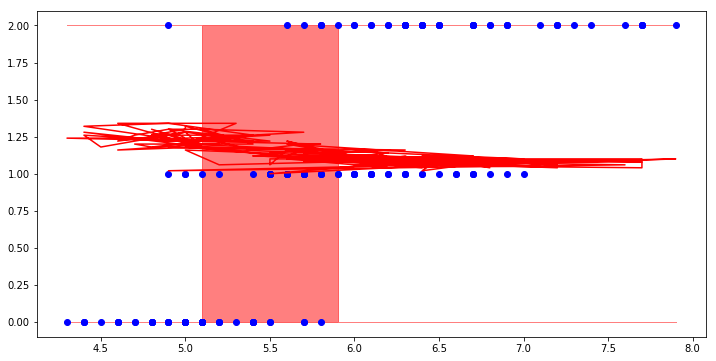

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=iris.data[:,0]
y_data = iris.target
plt.plot(x_values, y_data, "bo")
plt.plot(x_values, predictions1['mu_mean'], 'r');
plt.fill_between(x_values,
                   predictions1["mu_perc_5"],
                   predictions1["mu_perc_95"],
                   color='r',
                   alpha=0.5);

In [43]:
variances = pyro.param('variances')
means = pyro.param('means')

In [44]:
net = GaussianNaiveBayes(4, 3)
net.class_priors.data = my_class_priors
net.means = nn.Parameter(means)
net.variances = nn.Parameter(variances)

In [45]:
def predict(x):
    yhats = bayes_model.forward(x)
    return softmax(yhats)

predicted = torch.argmax(predict(feature_test_v), dim=1)
correct = 0
total = 0
for index, elem in enumerate(predicted):
    if elem == labels_test_v.tolist()[index]:
        correct += 1
    total += 1
print("accuracy: %d %%" % (100 * correct / total))

accuracy: 30 %
